# Evaluation

In [1]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from src import utils
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr
import random

utils.plot_style()
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)
os.makedirs('plots/', exist_ok=True)

In [2]:
intensity_scales = [50, 100, 200, 300, 400]
resolutions = [5, 10, 20, 30, 40]
n_cells = 20

## FISHFactor

In [3]:
df_list = []

for intensity_scale in intensity_scales:
    for cell in range(n_cells):
        data = torch.load('../../data/simulated/data/independent/{}_{}.pt'.format(intensity_scale, cell))
        results = pickle.load(open('results/fishfactor/{}_{}/final/latents.pkl'.format(intensity_scale, cell), 'rb'))

        z_inferred = results['z'][0]
        z_inferred = torch.nan_to_num(z_inferred, 0)
        z_inferred /= z_inferred.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
        z_data = data['z'][0]

        w_inferred = results['w']
        w_inferred /= w_inferred.max(dim=0)[0].view(1, data['n_factors'])
        w_data = data['w']

        inds, _ = utils.optimal_assignment(z_data, z_inferred, 0)

        z_inferred = z_inferred[inds]
        w_inferred = w_inferred[:, inds]
    
        w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
        z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

        df_list.append(pd.DataFrame({
            'intensity_scale' : intensity_scale,
            'cell' : cell,
            'w_corr' : w_corr,
            'z_corr' : z_corr,
            'avg_n_molecules_gene' : data['coordinates'].shape[0] / data['n_genes'],
            'model' : 'FISHFactor',
            'resolution' : 70 # just for plotting
        }, index=[0]))

fishfactor_evaluation = pd.concat(df_list).reset_index(drop=True)

In [4]:
fishfactor_evaluation.head(10)

,intensity_scale,cell,w_corr,z_corr,avg_n_molecules_gene,model,resolution
0,50,0,0.548573,0.600766,21.70,FISHFactor,70
1,50,1,0.221835,0.490311,22.36,FISHFactor,70
2,50,2,0.450895,0.617264,17.76,FISHFactor,70
3,50,3,0.115354,0.609918,23.36,FISHFactor,70
4,50,4,0.443454,0.675318,23.92,FISHFactor,70
5,50,5,0.738540,0.791453,18.20,FISHFactor,70
6,50,6,0.455421,0.672635,21.38,FISHFactor,70
7,50,7,0.185026,0.553981,22.64,FISHFactor,70
8,50,8,0.356797,0.686171,19.18,FISHFactor,70
9,50,9,0.604632,0.738187,16.90,FISHFactor,70


## NMF

In [5]:
df_list = []

for intensity_scale in intensity_scales:
    for cell in range(n_cells):
        for resolution in resolutions:
            data = torch.load('../../data/simulated/data/independent/{}_{}.pt'.format(intensity_scale, cell))
            results = torch.load('results/nmf/{}_{}/{}.pkl'.format(intensity_scale, cell, resolution))
            
            z_inferred = results['z']
            z_inferred /= z_inferred.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
            z_inferred = torch.nan_to_num(z_inferred, 0)
            z_data = data['z'][0]

            w_inferred = results['w']
            w_inferred /= np.clip(a=w_inferred.max(axis=0).reshape(1, data['n_factors']), a_min=1e-3, a_max=1e4)
            w_inferred = np.nan_to_num(w_inferred, 0)
            w_data = data['w']

            inds, _ = utils.optimal_assignment(z_data, z_inferred, 0)

            z_inferred = z_inferred[inds]
            w_inferred = w_inferred[:, inds]
            
            w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
            z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

            df_list.append(pd.DataFrame({
                'resolution' : resolution,
                'intensity_scale' : intensity_scale,
                'cell' : cell,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
                'avg_n_molecules_gene' : data['coordinates'].shape[0] / data['n_genes'],
                'model' : 'NMF'
            }, index=[0]))

nmf_evaluation = pd.concat(df_list).reset_index(drop=True)

In [6]:
nmf_evaluation.head(10)

,resolution,intensity_scale,cell,w_corr,z_corr,avg_n_molecules_gene,model
0,5,50,0,0.270274,0.425253,21.70,NMF
1,10,50,0,0.105730,0.241671,21.70,NMF
2,20,50,0,0.045503,0.150939,21.70,NMF
3,30,50,0,0.060873,0.128101,21.70,NMF
4,40,50,0,0.023474,0.092491,21.70,NMF
5,5,50,1,0.169166,0.334111,22.36,NMF
6,10,50,1,0.189288,0.359450,22.36,NMF
7,20,50,1,0.134430,0.256489,22.36,NMF
8,30,50,1,0.188535,0.183053,22.36,NMF
9,40,50,1,0.132771,0.122188,22.36,NMF


## NSF

In [7]:
df_list = []

for intensity_scale in intensity_scales:
    for cell in range(n_cells):
        for resolution in resolutions:
            data = torch.load('../../data/simulated/data/independent/{}_{}.pt'.format(intensity_scale, cell))
            try:
                results = pickle.load(open('results/nsf/{}_{}/{}.pkl'.format(intensity_scale, cell, resolution), 'rb'))
            except: continue
            z_inferred = results['z']
            z_inferred /= z_inferred.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
            z_inferred = torch.nan_to_num(z_inferred, 0)
            z_data = data['z'][0]

            w_inferred = results['w']
            w_inferred /= np.clip(a=w_inferred.max(axis=0).reshape(1, data['n_factors']), a_min=1e-3, a_max=1e4)
            w_inferred = np.nan_to_num(w_inferred, 0)
            w_data = data['w']

            inds, _ = utils.optimal_assignment(z_data, z_inferred, 0)

            z_inferred = z_inferred[inds]
            w_inferred = w_inferred[:, inds]
            
            w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
            z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

            df_list.append(pd.DataFrame({
                'resolution' : resolution,
                'intensity_scale' : intensity_scale,
                'cell' : cell,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
                'avg_n_molecules_gene' : data['coordinates'].shape[0] / data['n_genes'],
                'model' : 'NSF',
            }, index=[0]))

nsf_evaluation = pd.concat(df_list).reset_index(drop=True)

In [8]:
nsf_evaluation.head(10)

,resolution,intensity_scale,cell,w_corr,z_corr,avg_n_molecules_gene,model
0,5,50,0,0.523075,0.604801,21.70,NSF
1,10,50,0,0.286052,0.380172,21.70,NSF
2,20,50,0,0.338055,0.341785,21.70,NSF
3,30,50,0,0.367334,0.474991,21.70,NSF
4,40,50,0,0.279904,0.521916,21.70,NSF
5,5,50,1,0.363602,0.495574,22.36,NSF
6,10,50,1,0.425299,0.424649,22.36,NSF
7,20,50,1,0.363887,0.366063,22.36,NSF
8,30,50,1,0.420627,0.456680,22.36,NSF
9,40,50,1,0.194879,0.419237,22.36,NSF


## Benchmark plots

In [9]:
evaluation = pd.concat([nmf_evaluation, nsf_evaluation, fishfactor_evaluation])

In [10]:
plt.rcParams['axes.titlesize'] = 7

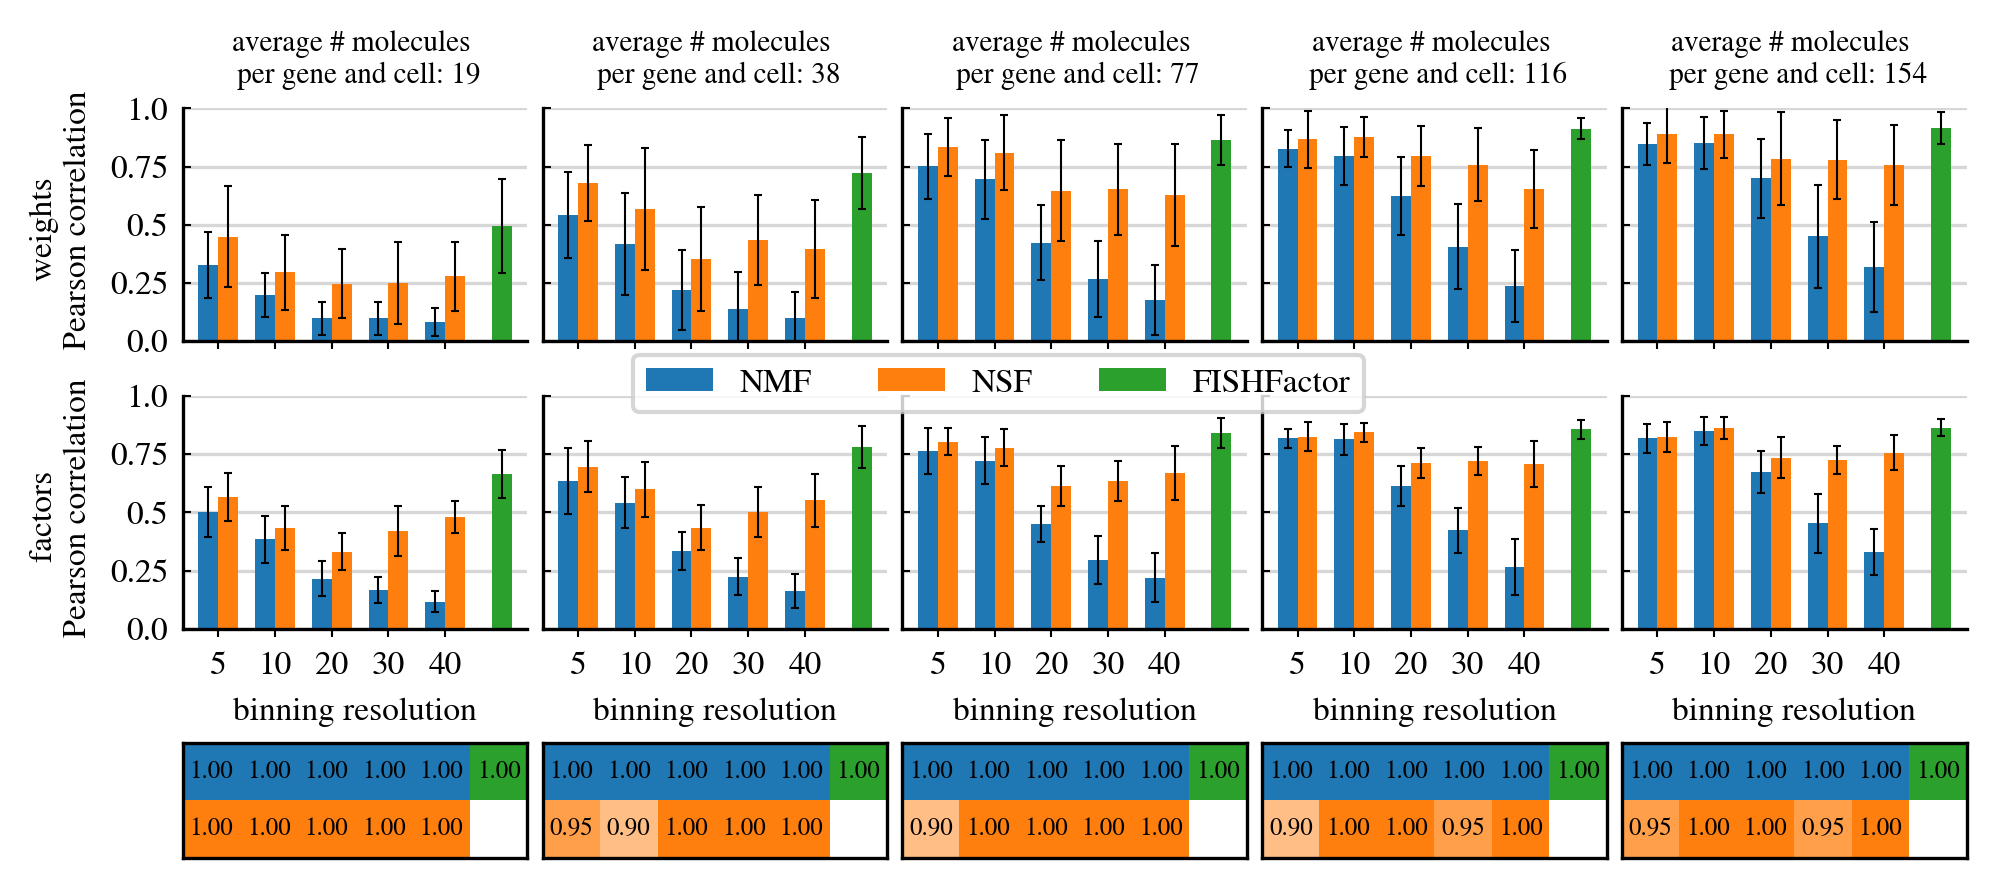

In [11]:
fig, axs = plt.subplots(3, 5, figsize=(6.5, 3), dpi=300)

for i, latent in enumerate(['w_corr', 'z_corr']):
    for j, intensity_scale in enumerate(intensity_scales):
        evaluation_subset = evaluation[evaluation.intensity_scale==intensity_scale]
        
        ax = axs[i, j]
        width = 0.35
        x = np.arange(5)
        
        ax.bar(
            x=x - width/2,
            height=evaluation_subset.query('model=="NMF"').groupby('resolution')[latent].mean().values,
            yerr=evaluation_subset.query('model=="NMF"').groupby('resolution')[latent].std().values,
            error_kw=dict(lw=0.5, capsize=1, capthick=0.5),
            width=width,
            label='NMF',
            color='C0'
            )
        ax.bar(
            x=x + width/2,
            height=evaluation_subset.query('model=="NSF"').groupby('resolution')[latent].mean().values,
            yerr=evaluation_subset.query('model=="NSF"').groupby('resolution')[latent].std().values,
            error_kw=dict(lw=0.5, capsize=1, capthick=0.5),
            width=width, 
            label='NSF',
            color='C1'
            )

        ax.bar(
            np.array([5]),
            height=evaluation_subset.query('model=="FISHFactor"')[latent].mean(),
            yerr=evaluation_subset.query('model=="FISHFactor"')[latent].std(),
            error_kw=dict(lw=0.5, capsize=1, capthick=0.5),
            width=width,
            label='FISHFactor',
            color='C2'
            )

        ax.set_xticks(np.arange(5))
        ax.set_xticklabels([])
        ax.set_yticks(np.linspace(0, 1, 5))
        ax.set_yticklabels([])
        ax.xaxis.set_tick_params(which='major', size=2, width=0.5, direction='out', top=False)
        ax.xaxis.set_tick_params(which='minor', size=1, width=0.5, direction='out', top=False)
        ax.yaxis.set_tick_params(which='major', size=2, width=0.5, direction='in', right=False)
        ax.yaxis.set_tick_params(which='minor', size=1, width=0.5, direction='in', right=False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_ylim(0, 1)

        ax.grid(alpha=0.5, axis='y')
        ax.set_axisbelow(True)

for i in range(2):
    axs[i, 0].set_yticklabels(np.linspace(0, 1, 5))
    axs[i, 0].set_ylabel('{} \n Pearson correlation'.format(['weights', 'factors'][i]))
        
for i, intensity_scale in enumerate(intensity_scales):
    evaluation_subset = evaluation[evaluation.intensity_scale==intensity_scale]
    axs[1, i].set_xticklabels(resolutions)
    axs[1, i].set_xlabel('binning resolution')
    axs[0, i].set_title('average # molecules \n per gene and cell: {}'.format(round(evaluation_subset.avg_n_molecules_gene.mean())))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, 0.6), loc='center', ncol=3)

for i, intensity_scale in enumerate(intensity_scales):
    evaluation_subset = evaluation[evaluation.intensity_scale==intensity_scale]
    n_nsf = (evaluation_subset.query('model=="NSF"').groupby('resolution').size() / 20).values
    n_nmf = (evaluation_subset.query('model=="NMF"').groupby('resolution').size() / 20).values
    n_fishfactor = (evaluation_subset.query('model=="FISHFactor"').groupby('resolution').size() / 20).values

    n_models = np.zeros([2, len(resolutions)+1])
    mask_nmf = np.ones([2, len(resolutions)+1])
    mask_nmf[0, :-1] = 0
    mask_nsf = np.ones([2, len(resolutions)+1])
    mask_nsf[1, :-1] = 0
    mask_fishfactor = np.ones([2, len(resolutions)+1])
    mask_fishfactor[0, -1] = 0
    n_models[0, :-1] = n_nmf
    n_models[1, :-1] = n_nsf
    n_models[0, -1] = n_fishfactor
    n_models[1, -1] = 0

    ax = axs[2, i]
    ax.matshow(np.ma.masked_array(n_models, mask_nmf), vmin=0.8, vmax=1, cmap=mpl.colors.LinearSegmentedColormap.from_list('C0_map', ['white', 'C0']))
    ax.matshow(np.ma.masked_array(n_models, mask_nsf), vmin=0.8, vmax=1, cmap=mpl.colors.LinearSegmentedColormap.from_list('C0_map', ['white', 'C1']))
    ax.matshow(np.ma.masked_array(n_models, mask_fishfactor), vmin=0.8, vmax=1, cmap=mpl.colors.LinearSegmentedColormap.from_list('C0_map', ['white', 'C2']))
    ax.set_xticks([])
    ax.set_yticks([])
    for (q, r), z in np.ndenumerate(n_models):
        if (q, r) == (1, 5):
            continue
        ax.text(r, q, '{:0.2f}'.format(z), ha='center', va='center', fontsize=6)


plt.tight_layout(pad=0.2)
plt.savefig('plots/benchmark_corr.svg')

# Factor visualizations

In [12]:
intensity_scale = 200
cell = 5
n_factors = 3

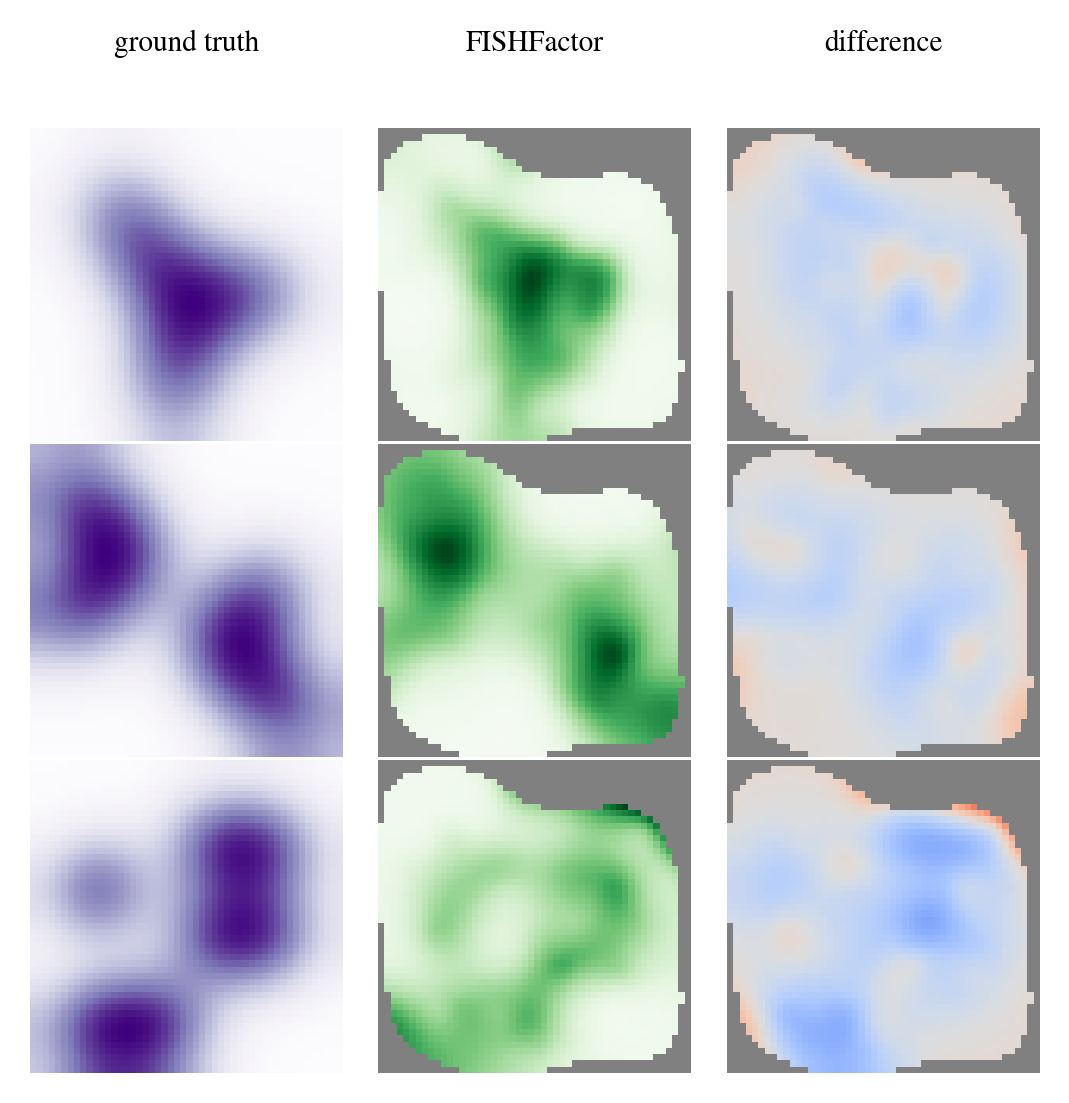

In [13]:
fig, axs = plt.subplots(n_factors, 3, figsize=(3.5, 3.5), dpi=300)

# ground truth
sim_data = torch.load('../../data/simulated/data/independent/{}_{}.pt'.format(intensity_scale, cell))
z_gt = sim_data['z'][0]

cmap = mpl.cm.get_cmap('Purples').copy()
for factor in range(n_factors):
    ax = axs[factor, 0]
    im = ax.matshow(z_gt[factor], origin='lower', cmap=cmap, vmin=0)
    ax.axis('off')
    #cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, location='bottom')
    #cbar.ax.set_xticks([0., 0.5, 1.])

# fishfactor
data = pickle.load(open('results/fishfactor/{}_{}/final/latents.pkl'.format(intensity_scale, cell), 'rb'))
z_fishfactor = data['z'][0]
z_fishfactor = torch.nan_to_num(z_fishfactor, 0)
mask = z_fishfactor < 1e-6
inds, _ = utils.optimal_assignment(sim_data['z'][0], z_fishfactor, 0)
z_fishfactor = z_fishfactor[inds]

cmap = mpl.cm.get_cmap('Greens').copy()
cmap.set_under(color='grey')
for factor in range(n_factors):
    ax = axs[factor, 1]
    im = ax.matshow(z_fishfactor[factor] / z_fishfactor[factor].max(), origin='lower', cmap=cmap, vmin=1e-6)
    ax.axis('off')
    #cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, location='bottom')
    #cbar.ax.set_xticks([0., 0.5, 1.])

# difference
cmap = mpl.cm.get_cmap('coolwarm').copy()
cmap.set_under(color='grey')
for factor in range(n_factors):
    diff = z_fishfactor[factor] / z_fishfactor[factor].max() - z_gt[factor] / z_gt[factor].max()
    diff[mask[factor]] = -2
    ax = axs[factor, 2]
    im = ax.matshow(diff, origin='lower', cmap=cmap, vmin=-1., vmax=1.)
    ax.axis('off')
    #cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, location='bottom')
    #cbar.ax.set_xticks([-1., 0., 1.])

axs[0, 0].set_title('ground truth')
axs[0, 1].set_title('FISHFactor')
axs[0, 2].set_title('difference')

plt.tight_layout(pad=0.1)
plt.savefig('plots/factors_gt_fishfactor_difference.svg')


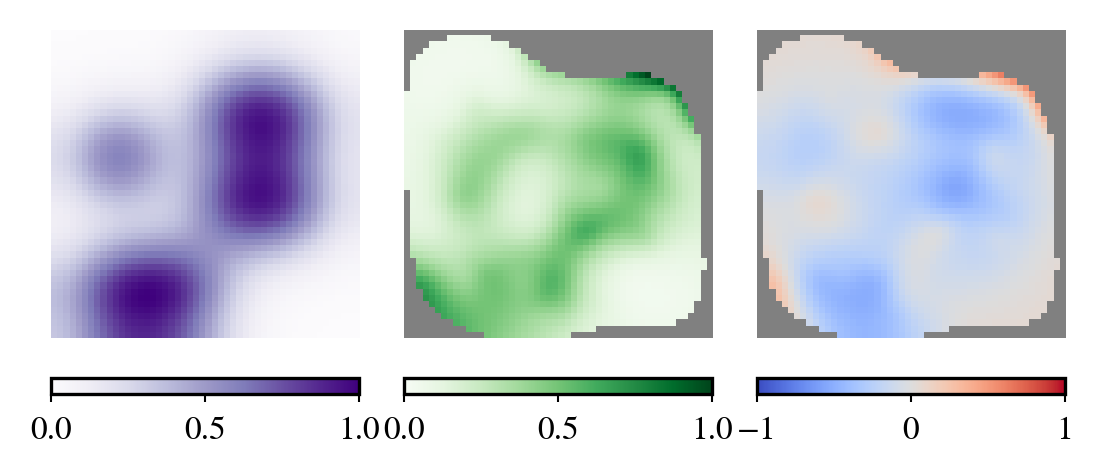

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(3.5, 3.5), dpi=300)

cmap = mpl.cm.get_cmap('Purples').copy()
ax = axs[0]
im = ax.matshow(z_gt[factor], origin='lower', cmap=cmap, vmin=0)
ax.axis('off')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, location='bottom')
cbar.ax.set_xticks([0., 0.5, 1.])

cmap = mpl.cm.get_cmap('Greens').copy()
cmap.set_under(color='grey')
ax = axs[1]
im = ax.matshow(z_fishfactor[factor] / z_fishfactor[factor].max(), origin='lower', cmap=cmap, vmin=1e-6)
ax.axis('off')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, location='bottom')
cbar.ax.set_xticks([0., 0.5, 1.])

# difference
cmap = mpl.cm.get_cmap('coolwarm').copy()
cmap.set_under(color='grey')
ax = axs[2]
im = ax.matshow(diff, origin='lower', cmap=cmap, vmin=-1., vmax=1.)
ax.axis('off')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, location='bottom')
cbar.ax.set_xticks([-1., 0., 1.])

plt.tight_layout(pad=0.1)
plt.savefig('plots/factors_gt_fishfactor_difference_colorbar.svg')

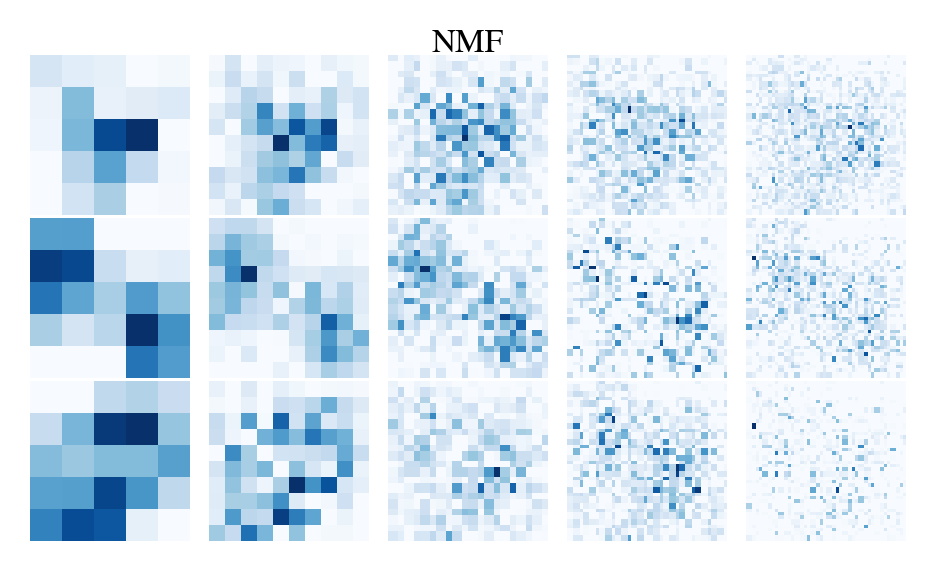

In [15]:
fig, axs = plt.subplots(n_factors, len(resolutions), figsize=(3, 1.75), dpi=300)

# NMF
cmap = mpl.cm.get_cmap('Blues').copy()
data_dict = {}
for resolution in resolutions:
    data_dict[resolution] = torch.load('results/nmf/{}_{}/{}.pkl'.format(intensity_scale, cell, resolution))
    
inds_dict = {}
for i, resolution in enumerate(resolutions):
    data = data_dict[resolution]
    z = data['z']
    z = torch.nan_to_num(z, 0)
    inds_dict[resolution], _ = utils.optimal_assignment(sim_data['z'][0], z, 0)
    z = z[inds_dict[resolution]]

    for factor in range(n_factors):
        ax = axs[factor, i]
        im = ax.matshow(z[factor] / z[factor].max(), origin='lower', cmap=cmap, vmin=0, vmax=1)
        ax.axis('off')

fig.suptitle('NMF')

plt.tight_layout(pad=0.1)
plt.savefig('plots/nmf.svg')

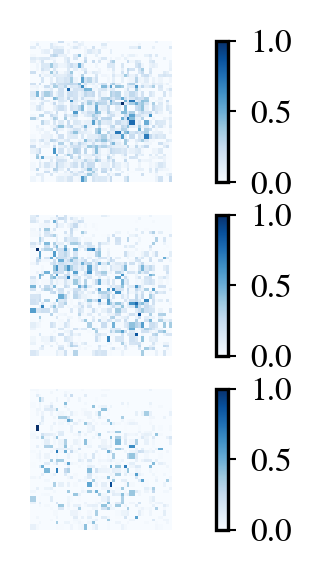

In [16]:
fig, axs = plt.subplots(n_factors, 1, figsize=(3, 1.75), dpi=300)

# NMF
cmap = mpl.cm.get_cmap('Blues').copy()
z = z[inds_dict[resolution]]

for factor in range(n_factors):
    ax = axs[factor]
    im = ax.matshow(z[factor] / z[factor].max(), origin='lower', cmap=cmap, vmin=0, vmax=1)
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, aspect=12)
    cbar.ax.set_yticks([0., 0.5, 1.])

plt.tight_layout(pad=0.1)
plt.savefig('plots/nmf_colorbar.svg')

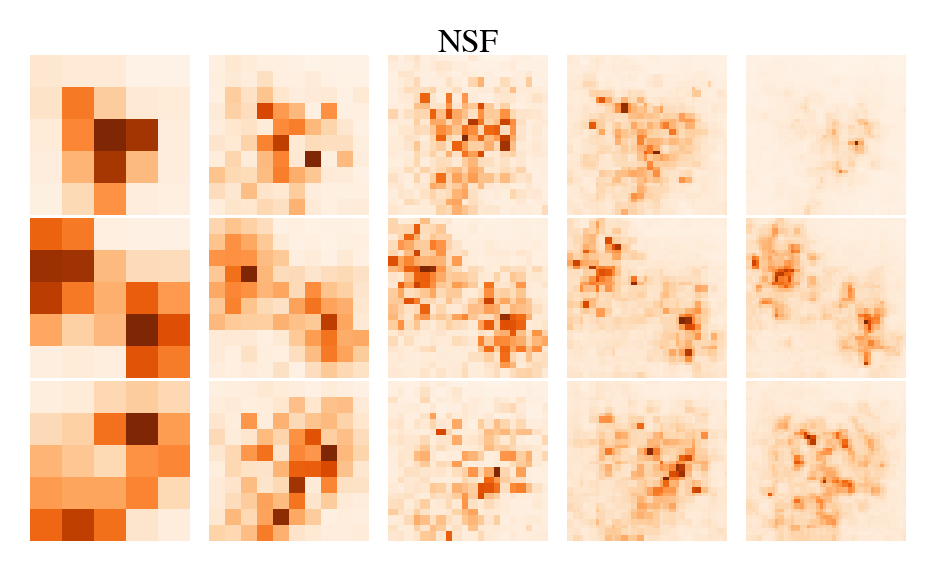

In [17]:
fig, axs = plt.subplots(n_factors, len(resolutions), figsize=(3, 1.75), dpi=300)

# NSF
cmap = mpl.cm.get_cmap('Oranges').copy()
data_dict = {}
for resolution in resolutions:
    data_dict[resolution] = pickle.load(open('results/nsf/{}_{}/{}.pkl'.format(intensity_scale, cell, resolution), 'rb'))
    
inds_dict = {}
for i, resolution in enumerate(resolutions):
    data = data_dict[resolution]
    z = data['z']
    z = torch.nan_to_num(z, 0)
    inds_dict[resolution], _ = utils.optimal_assignment(sim_data['z'][0], z, 0)
    z = z[inds_dict[resolution]]

    for factor in range(n_factors):
        ax = axs[factor, i]
        im = ax.matshow(z[factor] / z[factor].max(), origin='lower', cmap=cmap, vmin=0, vmax=1)
        ax.axis('off')
fig.suptitle('NSF')

plt.tight_layout(pad=0.1)
plt.savefig('plots/nsf.svg')

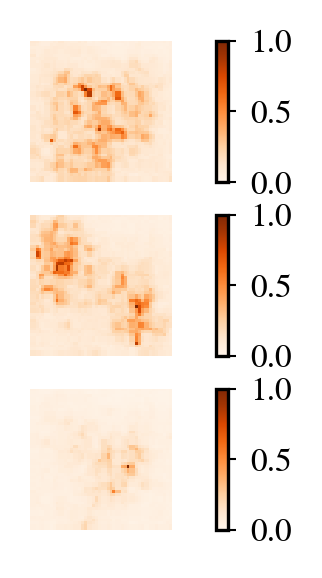

In [18]:
fig, axs = plt.subplots(n_factors, 1, figsize=(3, 1.75), dpi=300)

# NMF
cmap = mpl.cm.get_cmap('Oranges').copy()
z = z[inds_dict[resolution]]

for factor in range(n_factors):
    ax = axs[factor]
    im = ax.matshow(z[factor] / z[factor].max(), origin='lower', cmap=cmap, vmin=0, vmax=1)
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, aspect=12)
    cbar.ax.set_yticks([0., 0.5, 1.])

plt.tight_layout(pad=0.1)
plt.savefig('plots/nsf_colorbar.svg')

In [22]:
sim_data['coordinates'].shape[0] / sim_data['n_genes']

67.94